In [83]:
%matplotlib notebook


import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.13.0


### Task 2 Importing the data

In [84]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [85]:
x_train=np.reshape(x_train, (60000, 784))/255.
x_test=np.reshape(x_test, (10000,784))/255.
print(x_train.shape)

(60000, 784)


### Task 3 Plotting

In [86]:
def plot_triplet(triplet):
    plt.figure(figsize=(6, 2))
    for i in range(0, 3):
        plt.subplot(1, 3, i+1)
        plt.imshow(np.reshape(triplet[i],(28,28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()


<IPython.core.display.Javascript object>


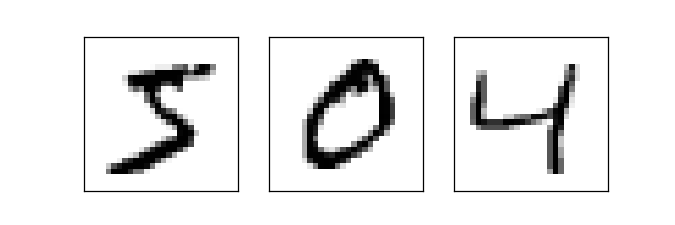

In [87]:
plot_triplet([x_train[0], x_train[1], x_train[2]])

## Task 4 Batch of triplets

In [88]:
def create_batch(batch_size):
    anchors=np.zeros((batch_size, 784))
    positives=np.zeros((batch_size, 784))
    negatives=np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        index=random.randint(0, 60000 - 1)
        anc=x_train[index]
        y=y_train[index]
        
        indices_for_pos=np.squeeze(np.where(y_train == y))
        indices_for_neg=np.squeeze(np.where(y_train != y))
        
        pos=x_train[indices_for_pos[random.randint(0, len(indices_for_pos) -1)]]
        neg=x_train[indices_for_neg[random.randint(0, len(indices_for_neg) -1)]]
        
        
        anchors[i]=anc
        positives[i]=pos
        negatives[i]=neg
        
    return [anchors, positives, negatives]

<IPython.core.display.Javascript object>


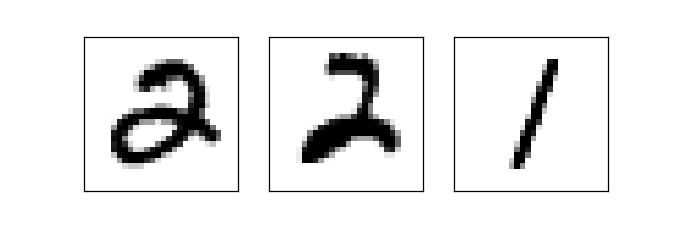

In [89]:
triplet=create_batch(1)
plot_triplet(triplet)

### TASK 5: Embedding model

In [90]:
emb_dim=64

embedding_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
Total params: 54400 (212.50 KB)
Trainable params: 54400 (212.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
example=x_train[0]
example_emb=embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

1/1 [==============================] - 0s 39ms/step
[0.52924436 0.35464045 0.5987607  0.51141286 0.5616968  0.6066597
 0.35773316 0.69000345 0.5714669  0.3117293  0.53497016 0.42844397
 0.3087617  0.49632555 0.40694275 0.51858693 0.2225627  0.63996017
 0.37256542 0.78735524 0.44553396 0.45841327 0.5826751  0.43960345
 0.59416157 0.4593552  0.628401   0.44002026 0.5137405  0.5221172
 0.5838303  0.47676757 0.4743411  0.44469678 0.54312027 0.38872832
 0.5700222  0.4796039  0.44347978 0.37372997 0.37754756 0.4519196
 0.59644866 0.4588016  0.48022074 0.5597253  0.5664298  0.36147848
 0.620044   0.60761505 0.5062597  0.5938616  0.56611586 0.59504783
 0.5346179  0.3510901  0.37048063 0.5704713  0.56944937 0.43000528
 0.6079073  0.617136   0.62170607 0.5375886 ]


### Task 6 Siamese Network

In [92]:
in_anc=tf.keras.layers.Input(shape=(784,))
in_pos=tf.keras.layers.Input(shape=(784,))
in_neg=tf.keras.layers.Input(shape=(784,))

em_anc=embedding_model(in_anc)
em_pos=embedding_model(in_pos)
em_neg=embedding_model(in_neg)

out= tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)


net=tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out

)
net.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 784)]                0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 64)                   54400     ['input_20[0][0]',            
                                                                     'input_21[0][0]',      

### Task 7: Triplet Loss

In [93]:
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg=y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp=tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn=tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp-dn + alpha, 0.)
    return loss


### Task 8: Data Generator

In [80]:
def data_generator(batch_size, emb_dim):
    while True:
        x=create_batch(batch_size)
        y=np.zeros((batch_size, 3*emb_dim))
        yield x, y       

### Task 9: Model Training

In [81]:
batch_size=1024
epochs=10
steps_per_epoch=int(60000/batch_size)

net.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_dim), optimizer='adam')

X, Y=x_test[:1000], y_test[:1000]

<IPython.core.display.Javascript object>


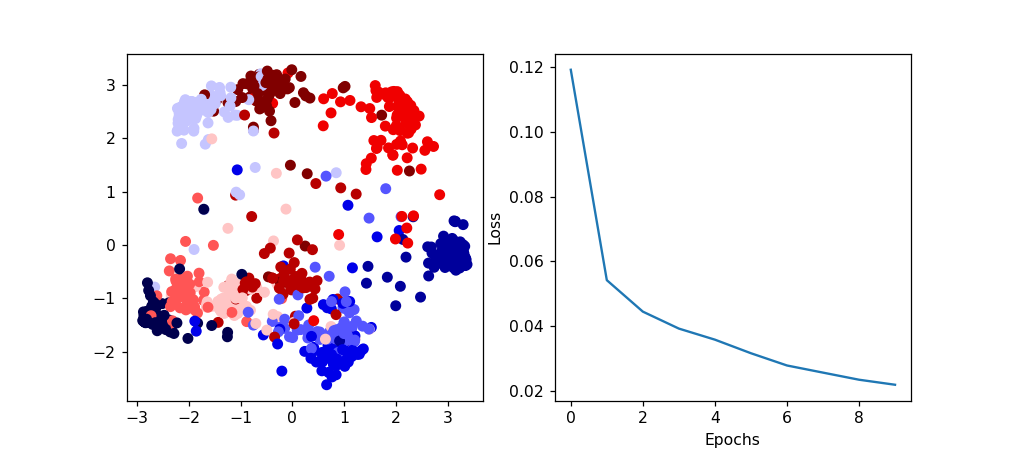

32/32 [==============================] - 0s 2ms/step


In [82]:
_ = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=False,
    callbacks=[
        PCAPlotter(plt, embedding_model, X, Y)
    ])